In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from random import randint, shuffle
import time
from datetime import datetime
                            

def display_metrics(probs, targets, history, threshold=0.5):
    '''
    Takes class probabilities assigned by a model and true class labels. Only intended for binary classifiers.
    
    Displays model performance metrics, confusion matrix, and a histogram of predicted scores.
    
    Returns model AUC.
    
    Args:
        probs -- class probabilities
        targets -- true class labels
    '''
    
    # Displays plots of the model's loss and AUC over the training epochs for the training and test sets
    
    print("Neural network performance")

    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Test loss')
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Test AUC')
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # preds are predicted class labels obtained from the class probabilities
    
    preds = np.array([1 if x >= threshold else 0 for x in probs])
    
    #preds = np.round(probs).flatten()
    
    true_neg = np.sum((targets == 0) & (preds == 0))
    false_pos = np.sum((targets == 0) & (preds == 1))

    sensitivity = 100 * recall_score(y_true=targets, y_pred=preds)
    specificity = 100 * true_neg / (true_neg + false_pos)
    accuracy = 100 * sum(preds == targets) / len(targets)
    auc = 100 * roc_auc_score(y_true=targets, y_score=probs)

    print("This model:")
    print("SN:",
              round(sensitivity, 2),
              '\t',
              "SP:",
              round(specificity, 2),
              '\t',
              "ACC:",
              round(accuracy, 2),
              '\t',
              "AUC:",
              round(auc, 2),
             )

    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No drug", "Drug"])
    disp.plot()
    plt.show()
    
    probs = np.array(probs)
    
    
    # Displays a histogram of class probabilities from 0 to 1, with positives and negatives separated
            
    pos_probs = np.array([probs[x] for x in range(len(probs)) if targets.iloc[x] == 1]).flatten()
    neg_probs = np.array([probs[x] for x in range(len(probs)) if targets.iloc[x] == 0]).flatten()
        
    plt.hist([pos_probs, neg_probs], alpha=0.5, bins=48, density=True, histtype = 'stepfilled', label=['Drugged proteins', 'Undrugged proteins'])
    plt.xlabel('Druggability score')
    plt.legend()
    plt.show()
    
    print("==========================================================================")
        
    return None
                                   
                                   
def fit_multiscore_nn(train_inputs, train_labels, test_inputs, test_labels):
    '''
    Fits a multilayer perceptron of a preset size on the provided train and test sets.
    
    Args:
        train_features
        train_labels
        test_features
        test_labels
        input_size -- scalar representing the # of features
    '''
        
    seq_and_struc_input = keras.Input(shape=(122,))
    
    seq_and_struc = layers.Dense(units=64, activation='relu', kernel_regularizer=l2)(seq_and_struc_input)
    
    seq_and_struc = layers.Dense(units=1, kernel_regularizer=l2)(seq_and_struc)
    
    
    localization_input = keras.Input(shape=(558,))
    
    localization = layers.Dense(units=512, activation='relu', kernel_regularizer=l2)(localization_input)
        
    localization = layers.Dense(units=1, kernel_regularizer=l2)(localization)
    
    
    bio_func_input = keras.Input(shape=(3464,))
    
    bio_func = layers.Dense(units=2048, activation='relu', kernel_regularizer=l2)(bio_func_input)
    
    bio_func = layers.Dense(units=1, kernel_regularizer=l2)(bio_func)

    
    network_info_input = keras.Input(shape=(8,))
    
    network_info = layers.Dense(units=8, activation='relu', kernel_regularizer=l2)(network_info_input)
    
    network_info = layers.Dense(units=1, kernel_regularizer=l2)(network_info)    
    
    subscores = layers.Concatenate(name='subscores')([seq_and_struc, localization, bio_func, network_info])
    
        
    model_output = tf.math.reduce_sum(subscores, axis=1)
    
    
    model = keras.Model(inputs=[seq_and_struc_input, localization_input, bio_func_input, network_info_input], outputs=model_output)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    model.compile(optimizer=Adam(learning_rate=10**-3.5), loss=bce, metrics=tf.keras.metrics.AUC(
        name="auc", from_logits=True))
    
    model.summary()
    
    with tf.device('/device:GPU:0'):
        history = model.fit(x=train_inputs, 
                            y=train_labels,
                            batch_size=32, 
                            epochs=200, 
                            shuffle=True,
                            validation_data=(test_inputs, test_labels),
                            callbacks=[callback],
                            verbose=verbose)
    
    return model, history


def k_split(input_set, k):
    '''
    Accepts an input dataframe and an integer k and randomly splits the input into k parts.
        
    Returns a list of length k containing the split sets.
    
    Args:
        input_set
        k
    '''
    
    input_len = len(input_set)
    
    next_n = 0
        
    k_assigns = np.array([])
        
    for i in range(input_len):
        if next_n == k:
            next_n = 0

        k_assigns = np.append(k_assigns, next_n)

        next_n += 1
        
    shuffle(k_assigns)

    input_set['k'] = k_assigns

    split_sets = []

    for i in range(k):
        set_k = input_set[input_set['k'] == i].drop('k', axis=1)

        split_sets.append(set_k)
        
    return split_sets


def process_set(protein_set):
    '''
    Accepts a set of proteins, including both features and labels.

    Returns protein names, features separated into different categories, and labels.

    Args:
        protein_set
    '''
    
    names = protein_set['Protein']
        
    seq_and_struc = protein_set[seq_and_struc_names]
    localization = protein_set[localization_names]
    bio_func = protein_set[bio_func_names]
    network_info = protein_set[network_info_names]
    
    labels = protein_set['drugged']

    return names, seq_and_struc, localization, bio_func, network_info, labels


def vanilla_oversample(split_sets):
    '''
    Accepts a list of dataframes representing a larget dataset split into k parts.
    
    Randomly oversamples the positive class within each dataframe to generate a new frame with balanced classes.
    
    Returns a list of the oversampled dataframes corresponding to the original list of imbalanced dataframes.
    
    Args:
        split_sets -- list of dataframes, each one consisting of an imbalanced dataset
    '''
    
    oversamples = []
    
    
    # Loops through the dataframes in split_sets and randomly oversamples the positive class
    # Appends the balanced frames to the list of oversampled frames
    
    for i in split_sets:   
        positives = i[i['drugged'] == 1]
        negatives = i[i.Protein.isin(positives['Protein']) == False]
        positives = positives.sample(n=len(negatives), replace=True)
        
        oversamples.append(pd.concat([positives, negatives]))
            
    return oversamples


def get_false_negatives(probs, labels, protein_names):
    preds = np.round(probs).flatten()
    
    false_neg = []
    
    for i in range(len(labels)):
        if labels.iloc[i] == 1 and preds[i] == 0:
            false_neg.append(protein_names.iloc[i])
    
    return false_neg


def shuffle_frame(df):
    df_copy = df.copy()
    
    df_copy = df_copy.sample(frac=1).reset_index(drop=True)
        
    return df_copy

    
mse = tf.keras.losses.MeanSquaredError()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


l2 = tf.keras.regularizers.L2(l2=0.001)
l1l2 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)

2022-11-19 01:50:20.331709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-19 01:50:20.331756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
full_set = pd.read_csv("processed_data/full_set.csv", index_col=0)

seq_and_struc_names = pd.read_csv("processed_data/seq_and_struc_names.csv", index_col=0, squeeze=True).tolist()
localization_names = pd.read_csv("processed_data/localization_names.csv", index_col=0, squeeze=True).tolist()
bio_func_names = pd.read_csv("processed_data/bio_func_names.csv", index_col=0, squeeze=True).tolist()
network_info_names = pd.read_csv("processed_data/network_info_names.csv", index_col=0, squeeze=True).tolist()

In [3]:
# Separates the validation data from the rest of the dataset
# Randomly splits the training and test sets k ways for cross-validation

validation_set = full_set[full_set.validation == 1].drop('validation', axis=1)

train_test_set = full_set[full_set.Protein.isin(validation_set['Protein']) == False].drop('validation', axis=1)

k = 5

split_sets = k_split(train_test_set, k)

In [4]:
validation_set

,Protein,symbol,sequence,name,drugged,90S preribosome,A band,AMPA glutamate receptor complex,AP-2 adaptor complex,Ada2/Gcn5/Ada3 transcription activator complex,...,Mean alp. sph. solvent access,Apolar alpha sphere proportion,Hydrophobicity score,Volume score,Polarity score,Charge score,Proportion of polar atoms,Alpha sphere density,Cent. of mass - Alpha Sphere max dist,Flexibility
12,P42695,NCAPD3,MVALRGLGSGLQPWCPLDLRLEWVDTVWELDFTETEPLDPSIEAEI...,Condensin-2 complex subunit D3,0,0.0,0.0,0.0,0.0,0.0,...,-0.209541,0.616019,0.769959,-0.757462,-0.589343,-0.410097,-0.083943,-0.139244,-0.053959,-1.215581
14,Q9NSA3,CTNNBIP1,MNREGAPGKSPEEMYIQQKVRVLLMLRKMGSNLTASEEEFLRTYAG...,Beta-catenin-interacting protein 1,0,0.0,0.0,0.0,0.0,0.0,...,1.178489,-0.144435,-0.229080,0.982861,-0.589343,-0.410097,-0.984614,-1.220839,-1.273250,0.860901
15,Q96KP4,CNDP2,MAALTTLFKYIDENQDRYIKKLAKWVAIQSVSAWPEKRGEIRRMME...,Cytosolic non-specific dipeptidase,0,0.0,0.0,0.0,0.0,0.0,...,0.758260,1.464007,-0.200744,0.659681,-0.764012,0.720977,-1.386952,-1.416516,-1.400414,0.204932
17,O95476,CTDNEP1,MMRTQCLLGLRTFVAFAAKLWSFFIYLLRRQIRTVIQYQTVRYDIL...,CTD nuclear envelope phosphatase 1,0,0.0,0.0,0.0,0.0,0.0,...,0.019675,0.047046,-0.879773,0.982861,-0.065336,-1.541171,0.717882,-0.675501,-0.559064,-0.369607
18,Q9BYD5,CNFN,MSYPVTSQPQCATTSCYQTQLSDWHTGLTDCCNDMPVCLCGTFAPL...,Cornifelin,0,0.0,0.0,0.0,0.0,0.0,...,1.496845,0.774675,0.750879,-1.440987,-0.938681,0.155440,-0.313899,-1.311247,-1.230221,0.878997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19849,Q9Y2G1,MYRF,MEVVDETEALQRFFEGHDINGALEPSNIDTSILEEYISKEDASDLC...,Myelin regulatory factor,0,0.0,0.0,0.0,0.0,0.0,...,-0.884454,1.682843,0.806276,0.360740,-0.414674,-0.975634,-1.566972,0.258303,0.055905,-0.043884
19850,Q8NFW9,MYRIP,MGRKLDLSGLTDDETEHVLQVVQRDFNLRKKEEERLSELKQKLDEE...,Rab effector MyRIP,0,0.0,0.0,0.0,0.0,0.0,...,-0.489694,0.233057,-0.447741,-0.812403,0.808009,0.720977,0.338574,1.339072,1.473483,-0.138886
19851,Q5VU43,PDE4DIP,MSNGYRTLSQHLNDLKKENFSLKLRIYFLEERMQQKYEASREDIYK...,Myomegalin,0,0.0,0.0,0.0,0.0,0.0,...,-0.922657,1.004452,1.199535,0.174911,-0.414674,-0.410097,-0.685341,0.728921,0.771865,0.648277
19856,Q96JP2,MYO15B,MKEASGVGGGHSPMCPPHCHMPPGPAGEWPGATVQQPRQRAPTALL...,Unconventional myosin-XVB,0,0.0,0.0,0.0,0.0,0.0,...,-0.336883,-1.151079,-0.601937,-0.250070,2.380030,0.720977,1.083280,2.290214,2.219016,0.453748


Split #:  1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 122)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 558)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3464)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 8)]          0           []                               
                                                                                  

2022-11-17 20:18:33.217862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-17 20:18:33.217897: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-17 20:18:33.217918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ky3zu0q2mj8sx7ob): /proc/driver/nvidia/version does not exist
2022-11-17 20:18:33.218320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
768/768 [==============================] - 14s 16ms/step - loss: 0.5481 - auc: 0.9885 - val_loss: 0.2900 - val_auc: 0.9211
Epoch 2/200
768/768 [==============================] - 11s 15ms/step - loss: 0.2179 - auc: 0.9961 - val_loss: 0.2685 - val_auc: 0.9412
Epoch 3/200
768/768 [==============================] - 11s 15ms/step - loss: 0.1853 - auc: 0.9973 - val_loss: 0.2510 - val_auc: 0.9345
Epoch 4/200
768/768 [==============================] - 11s 15ms/step - loss: 0.1713 - auc: 0.9974 - val_loss: 0.2263 - val_auc: 0.9414
Epoch 5/200
768/768 [==============================] - 11s 14ms/step - loss: 0.1605 - auc: 0.9980 - val_loss: 0.1968 - val_auc: 0.9264
Epoch 6/200
768/768 [==============================] - 11s 15ms/step - loss: 0.1514 - auc: 0.9981 - val_loss: 0.2019 - val_auc: 0.9340
Epoch 7/200
768/768 [==============================] - 11s 15ms/step - loss: 0.1441 - auc: 0.9982 - val_loss: 0.2056 - val_auc: 0.9406
Epoch 8/200
768/768 [==============================] - 

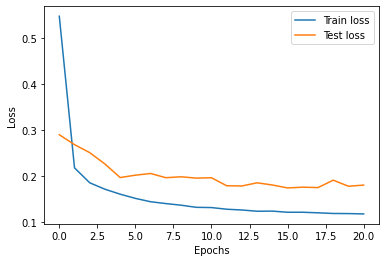

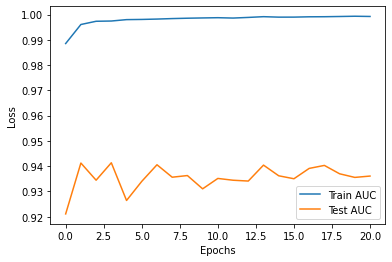

This model:
SN: 60.55 	 SP: 97.72 	 ACC: 96.45 	 AUC: 93.51


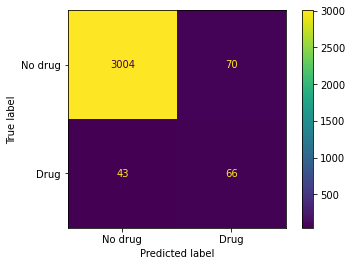

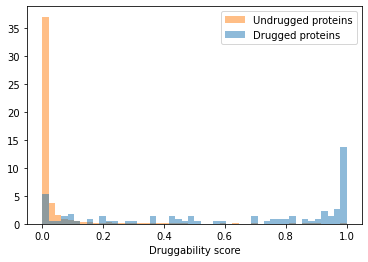

[93.5072493180448]
Time elapsed (s):  244.0162045955658


In [4]:
start_time = time.time()

verbose = True

aucs = []
final_test_losses = []


# n_trials is the number of cross-validation trials to perform
# Must be <= k, as each trial uses the next set in the k split as the test set

n_trials = 1

oversamples = vanilla_oversample(split_sets)

all_false_negs = []


# Iterates through the split sets, using the set at index i as the test set and all the others as the training set

for i in range(n_trials):
    
    train_sets = [oversamples[x] for x in range(k) if x != i]
                    
    train_set = pd.concat(train_sets)
    
    test_set = split_sets[i]
        
    train_names, train_seq_and_struc, train_localization, train_bio_func, train_network_info, train_labels = process_set(train_set)
    
    test_names, test_seq_and_struc, test_localization, test_bio_func, test_network_info, test_labels = process_set(test_set)
    
    train_inputs = [train_seq_and_struc, train_localization, train_bio_func, train_network_info]
    
    test_inputs = [test_seq_and_struc, test_localization, test_bio_func, test_network_info]
                                    
    print("Split #: ", i + 1)

    model, history = fit_multiscore_nn(train_inputs, train_labels, test_inputs, test_labels)
    
    
    # Predicts the labels of the test set using the model

    probs = tf.keras.activations.sigmoid(model.predict(test_inputs))    
    
    
    # Displays the metrics and graphs from the model's training
    
    display_metrics(probs, test_labels, history)
    
    
    # Saves the model's performance as measured by test AUC
            
    aucs.append(100 * roc_auc_score(y_true=test_labels, y_score=probs))
    
    
    # Saves the model's performance as measured by test loss
    
    score = model.evaluate(test_inputs, test_labels, verbose=False)
        
    final_test_losses.append(score[0])
    
    
    # Gets the false negatives and adds them to the list
    
    false_negs = get_false_negatives(probs, test_labels, test_names)
    
    all_false_negs += false_negs
    

# Displays the AUC for each trial and the time elapsed in the experiment

print(aucs)
    
elapsed_time = time.time() - start_time

print("Time elapsed (s): ", elapsed_time)

In [5]:

# threshold = 0.5

# # font = {'family' : 'Arial',
# #         'weight' : 'bold',
# #         'size'   : 8}

# # plt.rc('font', **font)

# preds = np.array([1 if x >= threshold else 0 for x in probs])
   
# pos_probs = np.array([probs[x] for x in range(len(probs)) if test_labels.iloc[x] == 1]).flatten()
# neg_probs = np.array([probs[x] for x in range(len(probs)) if test_labels.iloc[x] == 0]).flatten()

# cm = confusion_matrix(test_labels, preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No drug", "Drug"])
# disp.plot()
# plt.show()

# plt.hist([pos_probs, neg_probs], alpha=0.5, bins=48, density=True, histtype = 'stepfilled', label=['Drugged proteins', 'Undrugged proteins'])
# plt.xlabel('Druggability score', fontname="Arial", fontsize=12)
# plt.legend()
# plt.show()

In [6]:
def get_subscores(features, labels, model):            
    subscores_model = keras.Model(inputs=model.input, outputs=model.get_layer('subscores').output)
    subscores_output = subscores_model.predict(features, verbose=False)
    total_scores = tf.math.reduce_sum(subscores_output, axis=1)
    
    drug_probs = tf.keras.activations.sigmoid(tf.reshape(total_scores, shape=(len(total_scores),1))) * 100

    subscores_output = tf.concat([drug_probs, subscores_output], axis=1)
            
    return subscores_output
    

def analyze_protein(poi_id, names, protein_labels, subscores):     
    poi_pos = names.index.get_loc(names.index[names == poi_id][0])
        
    plot_names = ['Druggability likelihood (%):',
                  'Sequence and structure score:', 
                  'Localization score:', 
                  'Biological function score:', 
                  'Network information score:']
        
    for i in range(5):
        pos_probs = np.array([subscores[x,i] for x in range(len(subscores)) if protein_labels.iloc[x] == 1]).flatten()
        neg_probs = np.array([subscores[x,i] for x in range(len(subscores)) if protein_labels.iloc[x] == 0]).flatten()
        
        subscore_auc = roc_auc_score(y_true=protein_labels, y_score=subscores[:,i])
                
        plt.hist([pos_probs, neg_probs], label=['Drugged proteins', 'Undrugged proteins'], alpha=0.5, bins=48, density=True, histtype = 'stepfilled')
        plt.vlines(subscores[poi_index,i], ymin=0, ymax=1, colors='black', linestyles='dashed', label='{} score'.format(poi_id))
        
        print("==================================================================================================")
        print(plot_names[i], round(float(subscores[poi_index,i]), 2))
        print("AUC:", round(subscore_auc, 3))
        plt.legend()
        plt.show()

Druggability likelihood (%): 0.21
AUC: 0.935


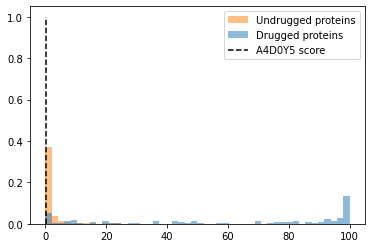

Sequence and structure score: -1.13
AUC: 0.744


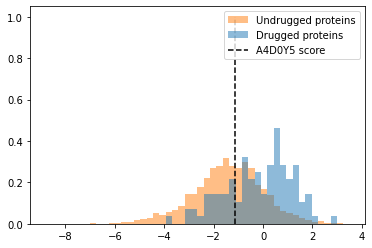

Localization score: 0.34
AUC: 0.722


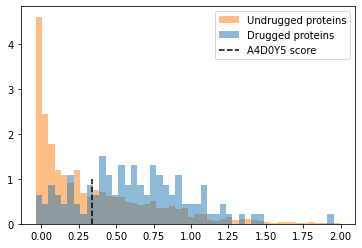

Biological function score: -5.04
AUC: 0.891


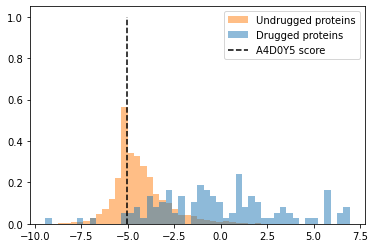

Network information score: -0.34
AUC: 0.804


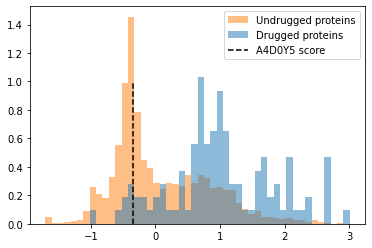

In [7]:
poi_index = test_labels.argmin()

poi = test_set['Protein'].iloc[poi_index]

subscores = get_subscores(test_inputs, test_labels, model)

analyze_protein(poi, test_names, test_labels, subscores)

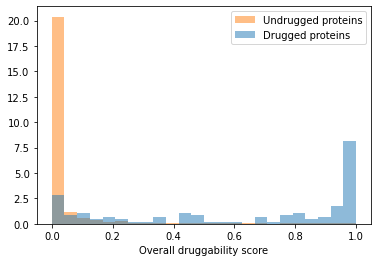

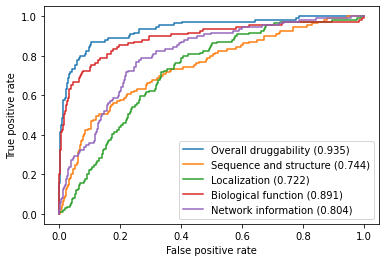

In [30]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

pos_probs = np.array([probs[x] for x in range(len(probs)) if test_labels.iloc[x] == 1]).flatten()
neg_probs = np.array([probs[x] for x in range(len(probs)) if test_labels.iloc[x] == 0]).flatten()

plt.hist([pos_probs, neg_probs], alpha=0.5, bins=24, density=True, histtype = 'stepfilled', label=['Drugged proteins', 'Undrugged proteins'])
plt.xlabel('Overall druggability score')
plt.legend()
plt.show()

plot_labels = ['Overall druggability',
              'Sequence and structure', 
              'Localization', 
              'Biological function', 
              'Network information']

for i in range(5):
    fpr, tpr, _ = roc_curve(test_labels, subscores[:,i])
    auc = roc_auc_score(test_labels, subscores[:,i])
    plt.plot(fpr, tpr, label=plot_labels[i] + " (" + str(round(auc, 3)) + ")")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
             
plt.legend()
plt.show()